In [1]:
import os
import ast
import glob
import numpy as np
import pandas as pd
import pysgpp as pysgpp

from sklearn.model_selection import train_test_split

from pysgpp.extensions.datadriven.learner import Types
from pysgpp.extensions.datadriven.learner import LearnerBuilder
from pysgpp.extensions.datadriven.uq.plot.plot1d import plotSG1d
from pysgpp.extensions.datadriven.uq.plot.plot2d import plotSG2d,plotGrid2d
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
from pysgpp.extensions.datadriven.uq.plot.plotGrid import plotGrid
from pysgpp.extensions.datadriven.learner.folding import RandomFoldingPolicy

import matplotlib.pyplot as plt
from sklearn import preprocessing

plt.style.use('ggplot')
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parse_times(filename):
    df = pd.read_csv(filename, header = None, names = ['params', 'time'])
    df.params = df.params.apply(ast.literal_eval)
    for param in df.iloc[0].params.keys():
        df[param] = df.params.apply(lambda row: row[param])
    df['density'] = (df.MOL_X*df.MOL_Y)/(df.DOMAIN_SIZE_X*df.DOMAIN_SIZE_Y)
    del df['params']
    return df

# combine all the data frames we have in the data/* dir
dfList = map(parse_times, glob.glob('data/*.csv'))
df = reduce(lambda x, y: x.append(y), dfList)

In [3]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
df.sample(15)

,BLOCK_SIZE,CHECKPOINT,CUTOFF_RADIUS,DELTA_T,DOMAIN_SIZE_X,DOMAIN_SIZE_Y,LINKED_CELL_SIZE_X,LINKED_CELL_SIZE_Y,MOL_X,MOL_Y,TEMP,TIMESTEPS,V_x,V_y,density,time
56,2,checkpoints/QV711G7LEV_999,3.00,0.002,80,30,20.0,15.0,25,30,2.5,1000,1,1.5,0.312500,7.640636
142,1,checkpoints/MAKUGVJFUK_999,1.00,0.002,50,30,10.0,10.0,55,20,2.5,1000,1,1.5,0.733333,9.904344
406,2,checkpoints/8F5LQZZUQ3_999,3.75,0.002,50,70,15.0,15.0,35,45,2.5,1000,1,1.5,0.450000,13.715985
719,1,checkpoints/R0Q0QZH1VA_999,3.00,0.002,70,65,7.5,7.5,45,60,2.5,1000,1,1.5,0.593407,10.417022
641,1,checkpoints/OQKEQYT7GL_999,3.50,0.002,90,60,15.0,20.0,40,20,2.5,1000,1,1.5,0.148148,4.757987
999,1,checkpoints/G9PN85NR8N_999,2.25,0.002,70,30,7.5,10.0,40,40,2.5,1000,1,1.5,0.761905,9.649553
1110,1,checkpoints/JK6MOABR4D_999,2.25,0.002,40,70,7.5,10.0,20,35,2.5,1000,1,1.5,0.250000,4.070789
127,2,checkpoints/2JBZGP6U1C_999,4.00,0.002,50,40,15.0,20.0,45,25,2.5,1000,1,1.5,0.562500,19.972897
493,1,checkpoints/CJZ2CNY49T_999,4.50,0.002,50,90,10.0,20.0,15,30,2.5,1000,1,1.5,0.100000,2.728717
464,1,checkpoints/CSF066WD47_999,4.75,0.002,30,65,10.0,12.5,80,40,2.5,1000,1,1.5,1.641026,NaN


In [5]:
columns = ['DOMAIN_SIZE_X', 'DOMAIN_SIZE_Y', 'MOL_X', 'MOL_Y', 'LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y',
          'BLOCK_SIZE', 'CUTOFF_RADIUS', 'density','time']

params = ['CUTOFF_RADIUS', 'density', 'MOL_Y','MOL_X','DOMAIN_SIZE_Y',
           'DOMAIN_SIZE_X','MOL_X','LINKED_CELL_SIZE_X', 'LINKED_CELL_SIZE_Y']

In [6]:
normalized_df = normalize(df[df.time > 0][columns])
train, test = train_test_split(normalized_df, test_size=0.2)
num_samples = train.shape[0]

In [7]:
X_train = train[params].values
Y_train = train['time'].values

In [8]:
X_test = test[params].values
Y_test = test['time'].values

In [9]:
levels = 2
builder = LearnerBuilder()
builder.buildRegressor()
builder.withTrainingDataFromNumPyArray(X_train, Y_train)
builder.withTestingDataFromNumPyArray(X_test, Y_test)
builder = builder.withGrid().withBorder(Types.BorderTypes.NONE)
builder.withLevel(levels)
builder = builder.withSpecification()
builder.withLambda(0.000001).withAdaptPoints(100)

#builder.withRandomFoldingPolicy().withLevel(4)

builder.withIdentityOperator()
builder = builder.withStopPolicy()
builder = builder.withCGSolver()
builder.withAccuracy(0.0001)
builder.withImax(1000)
learner = builder.andGetResult()

#learner.learnData()
#learner.learnDataWithFolding()
learner.learnDataWithTest()
print 'Test accuracy:' + str(learner.testAccuracy)
print 'Level: %i' % levels
print 'L2Norm: %f' % learner.getL2NormError()
print 'MaxError: %f' % learner.getMaxError()
print 'MinError: %f' % learner.getMinError()
print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
print 'RMSerror: %f' % learner.error.RMSNorm()
print 'Grid size BEFORE refinement: %i' % learner.grid.getSize()
print 'Refining grid.. '
learner.refineGrid()
learner.learnData()
print 'Grid size AFTER refinement: %i' % learner.grid.getSize()
print 'Test accuracy:' + str(learner.testAccuracy)
print 'L2Norm: %f' % learner.getL2NormError()
print 'MaxError: %f' % learner.getMaxError()
print 'MinError: %f' % learner.getMinError()
print 'Error: %f' % learner.evalError(learner.dataContainer,learner.alpha)
print 'RMSerror: %f' % learner.error.RMSNorm()
print '--------------------------------------------'

Test accuracy:[0.0029997796546014756]
Level: 2
L2Norm: 0.932704
MaxError: 0.345132
MinError: 0.000197
Error: 0.002375
RMSerror: 0.013772
Grid size BEFORE refinement: 19
Refining grid.. 
Grid size AFTER refinement: 199
Test accuracy:[0.0029997796546014756]
L2Norm: 0.788457
MaxError: 0.277215
MinError: 0.000014
Error: 0.000536
RMSerror: 0.002945
--------------------------------------------


In [13]:
def generatePairPlots(X, y, grid, alpha, title = '', outdir = None):
    n = X.shape[0]
    time_estimations = []
    p = pysgpp.DataVector(len(params))
    for i in range(n):
        for j, v in enumerate(X[i,]):
            p[j] = v
        opEval = pysgpp.createOperationEval(grid)
        time_estimations.append(opEval.eval(alpha, p))

    for i, p in enumerate(params):
        plt.figure()
        plt.xlabel(p)
        plt.ylabel('time')
        plt.title(title)
        plt.scatter(X[:,i], y, color = 'b')
        sorted_test, sorted_estimations = zip(*sorted(zip(X[:,i], time_estimations)))
        plt.plot(sorted_test, sorted_estimations, color = 'r', linestyle = '-.')
        if outdir:
            plt.savefig(os.path.join(outdir, p + '.png'))

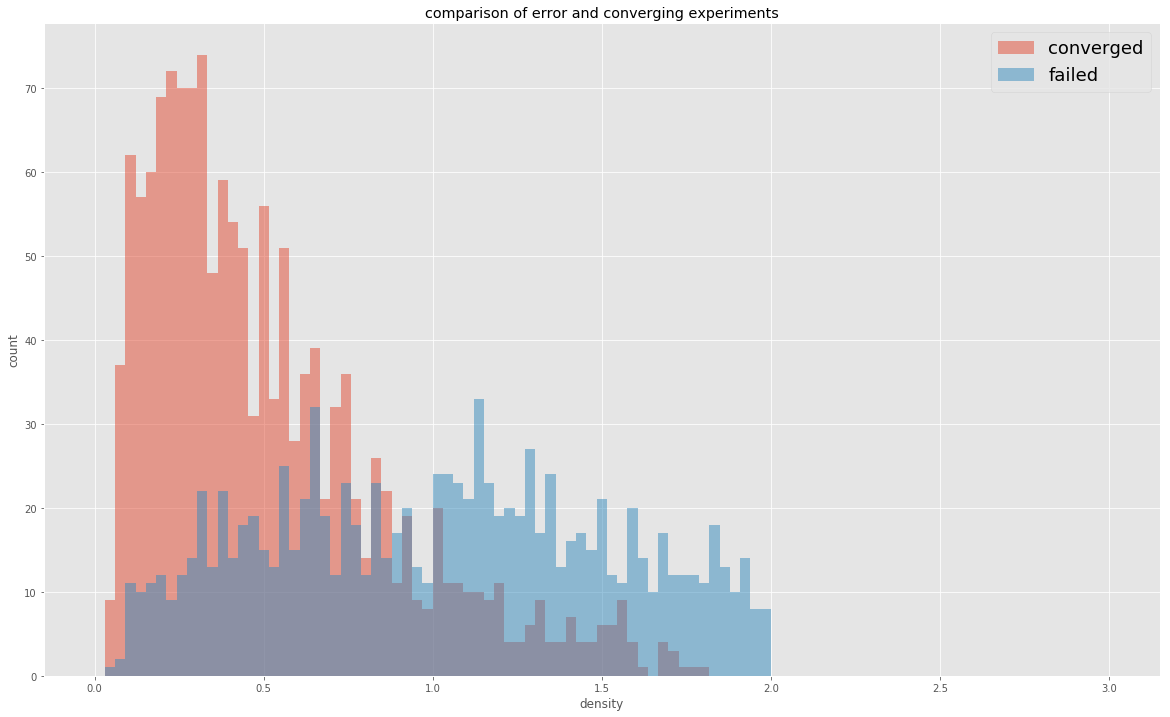

In [11]:
failed = df[df.time.isnull()].density
converged = df[~df.time.isnull()].density

bins = numpy.linspace(0, 3, 100)

plt.hist(converged, bins, alpha=0.5, label='converged')
plt.hist(failed, bins, alpha=0.5, label='failed')
plt.title('comparison of error and converging experiments')
plt.xlabel('density')
plt.ylabel('count')
plt.legend(loc='upper right', prop={'size': 18})
plt.show()

plt.savefig('failures.png')

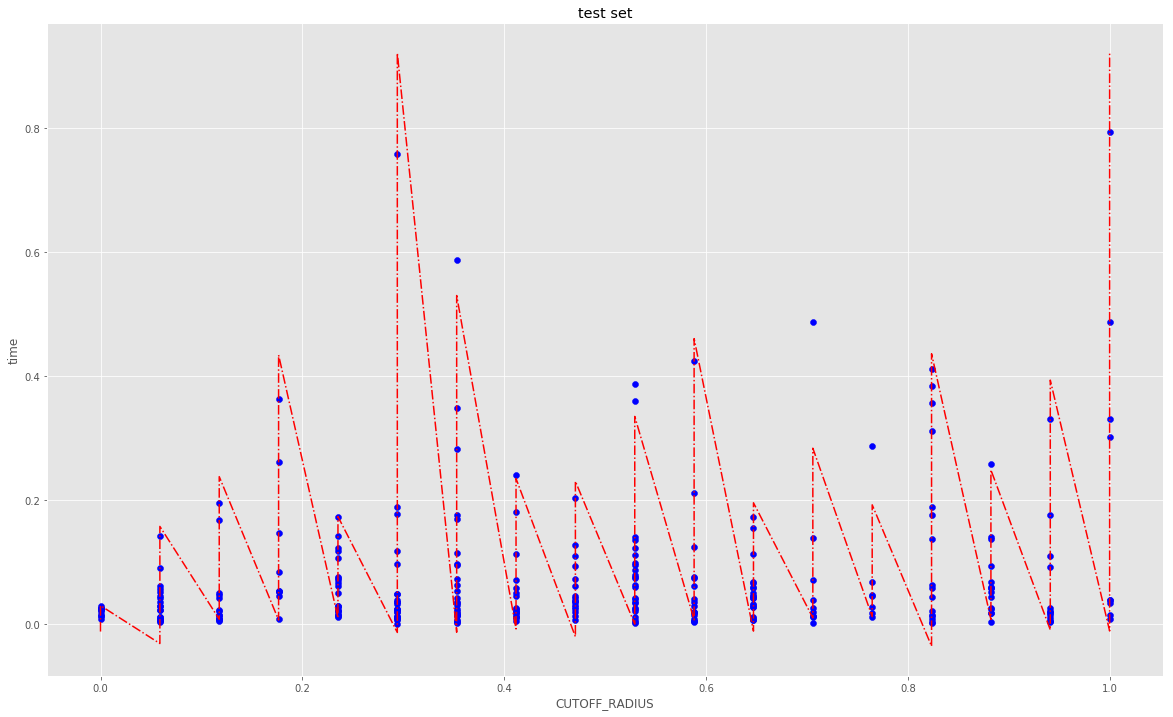

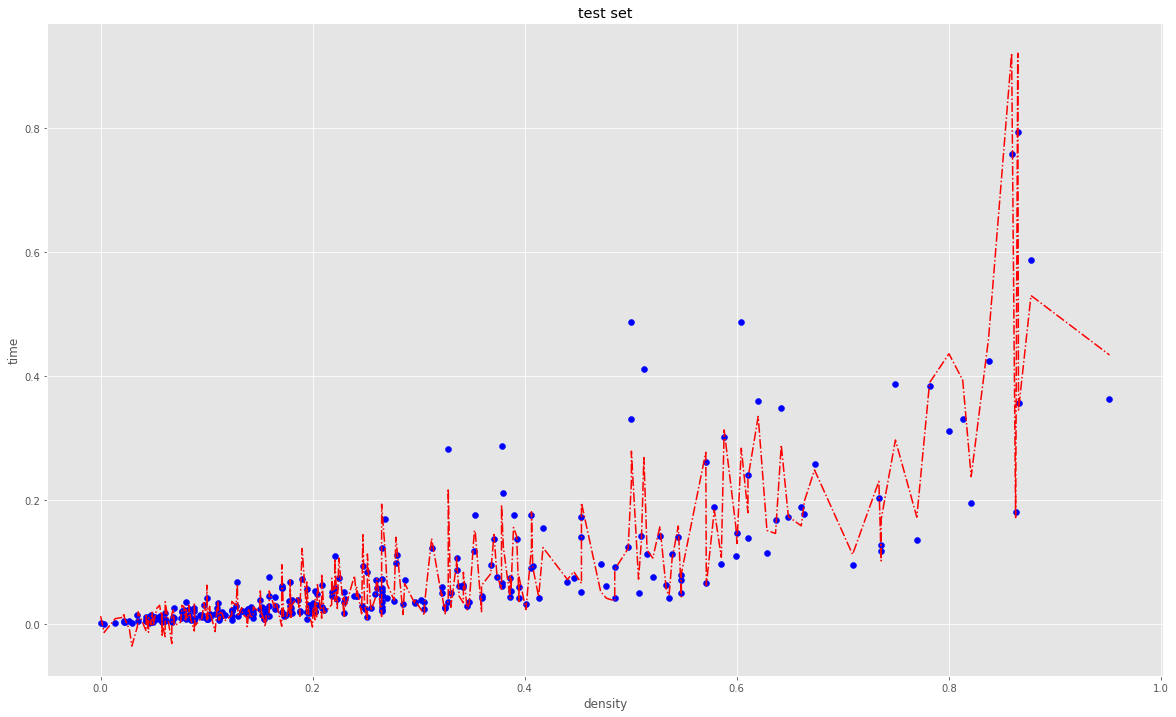

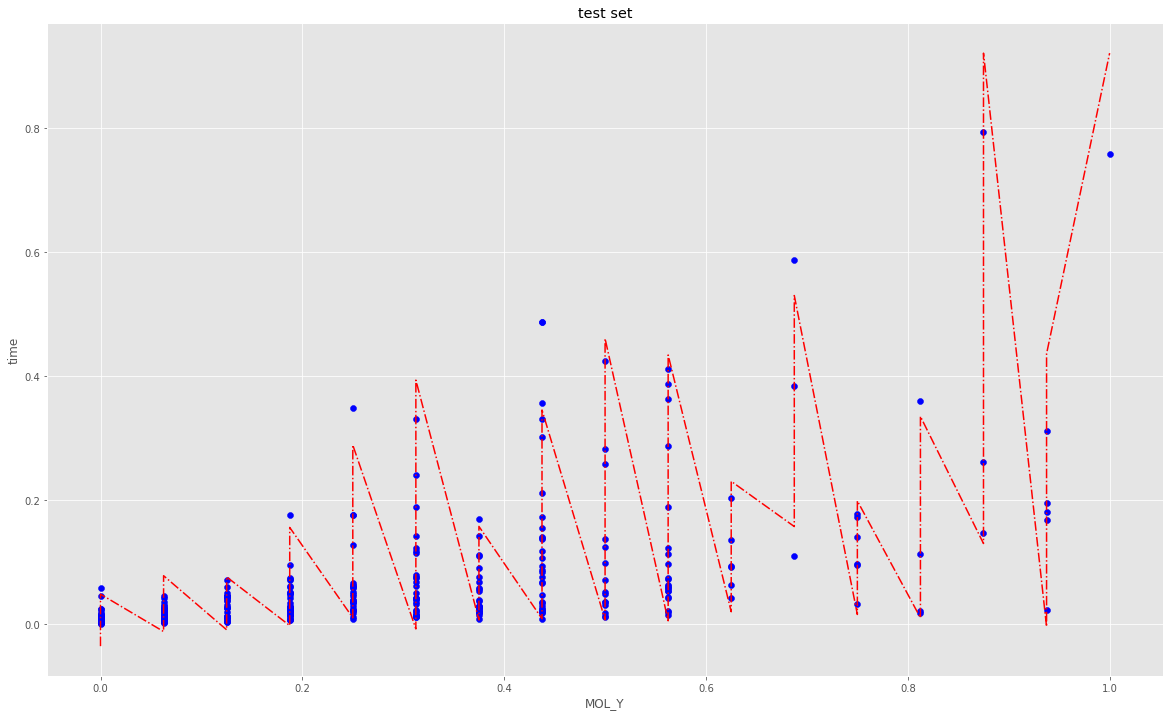

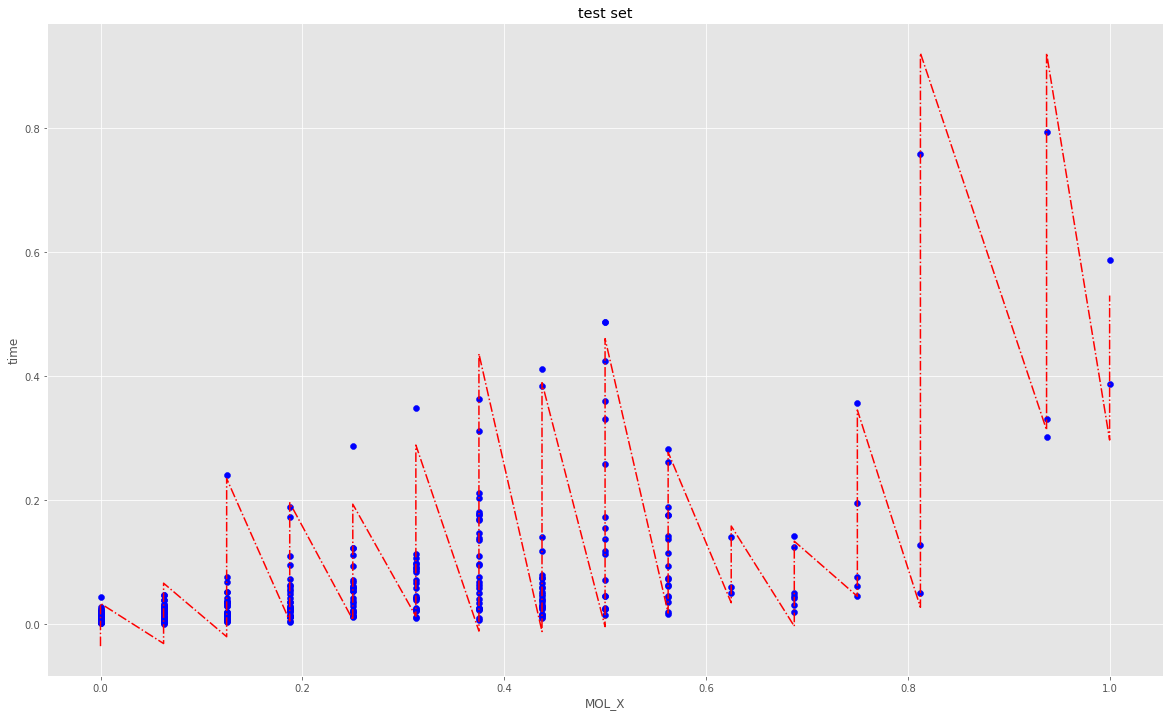

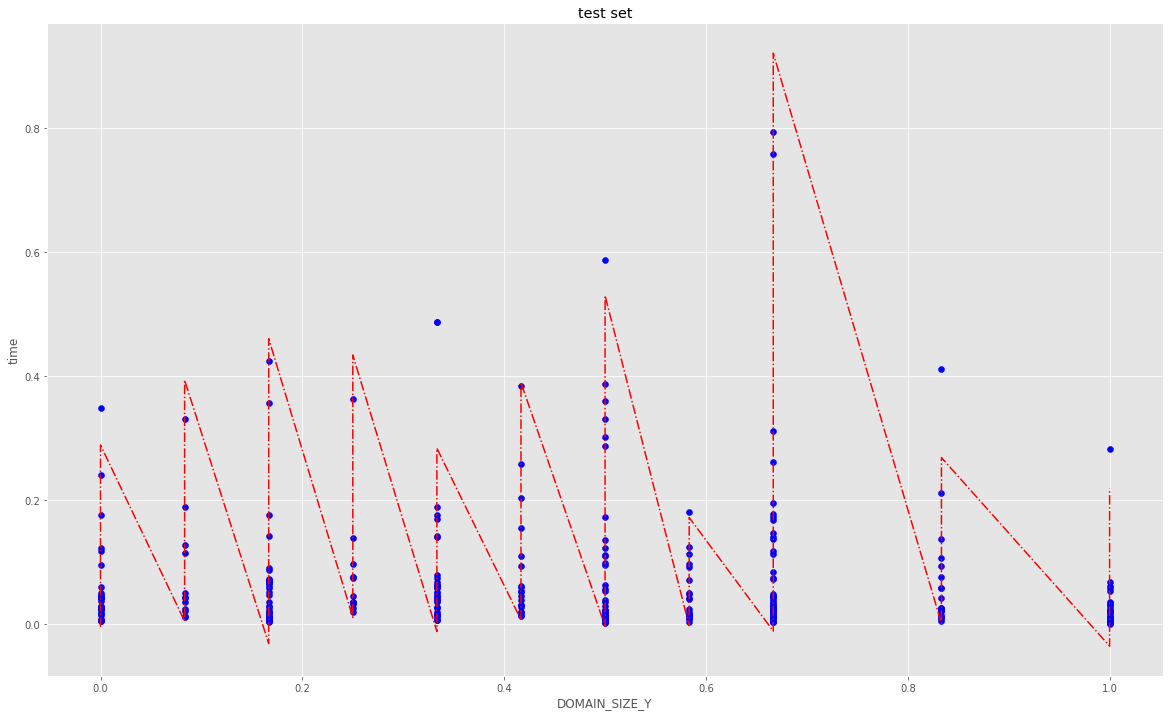

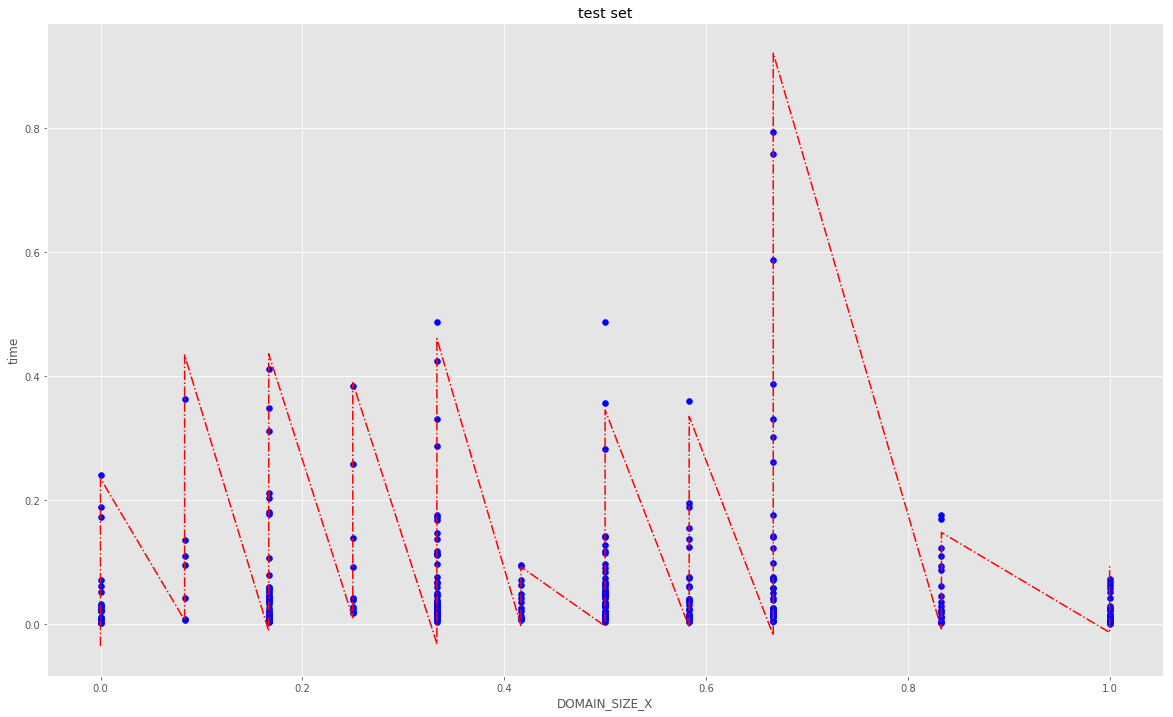

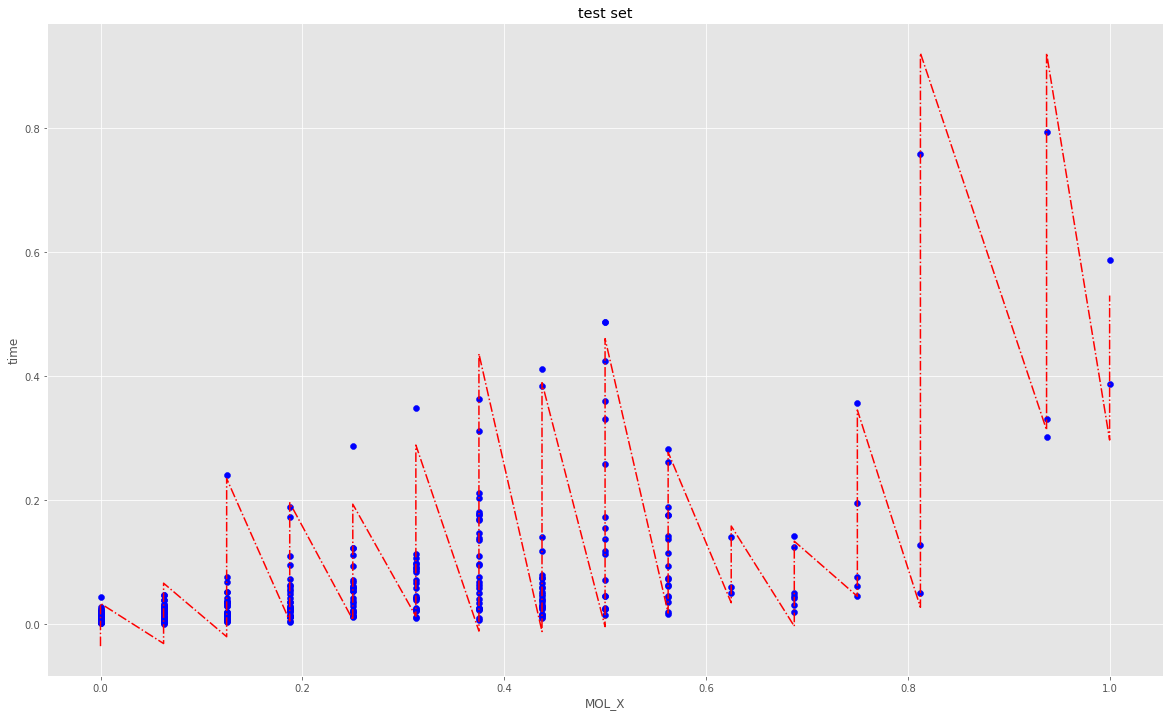

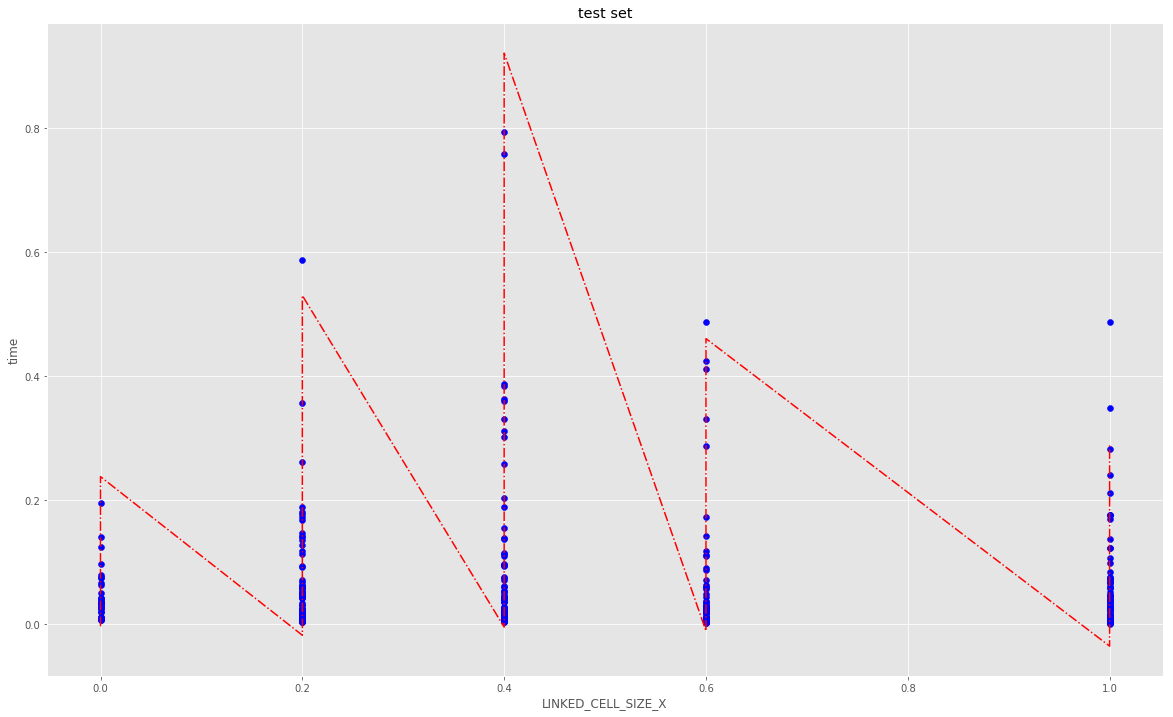

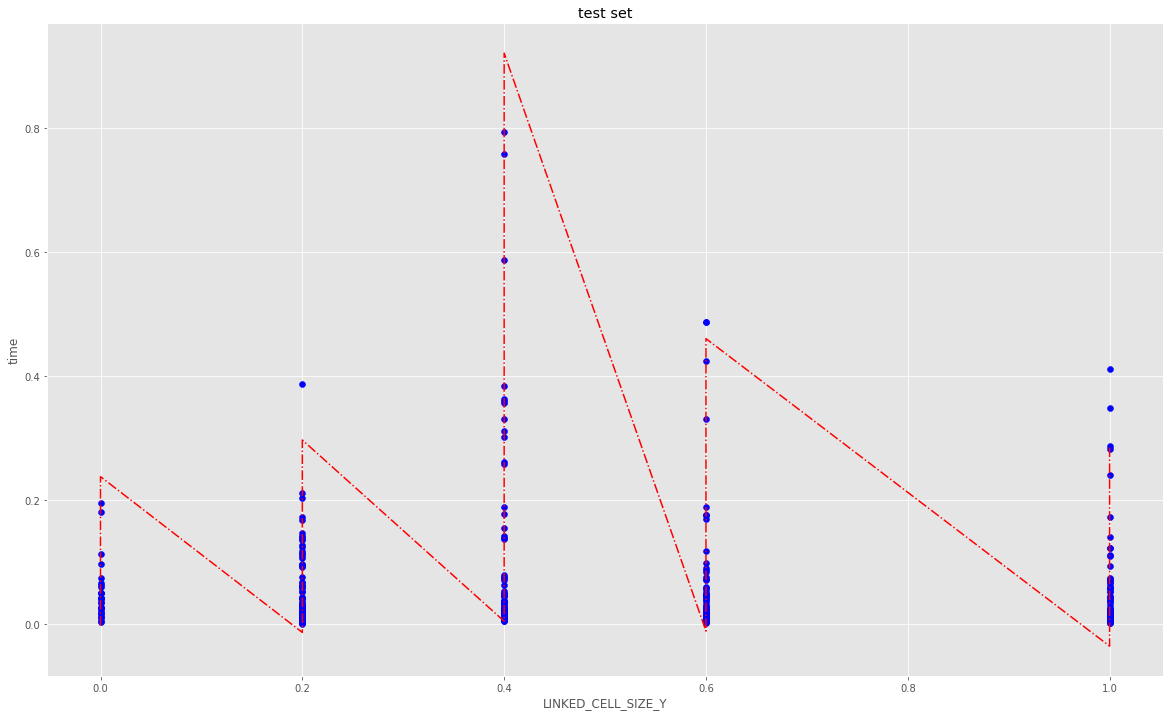

In [14]:
generatePairPlots(X_test, Y_test, learner.grid, learner.alpha, title = 'test set', outdir = '/media/sf_sparse_grids/pairPlots/test')

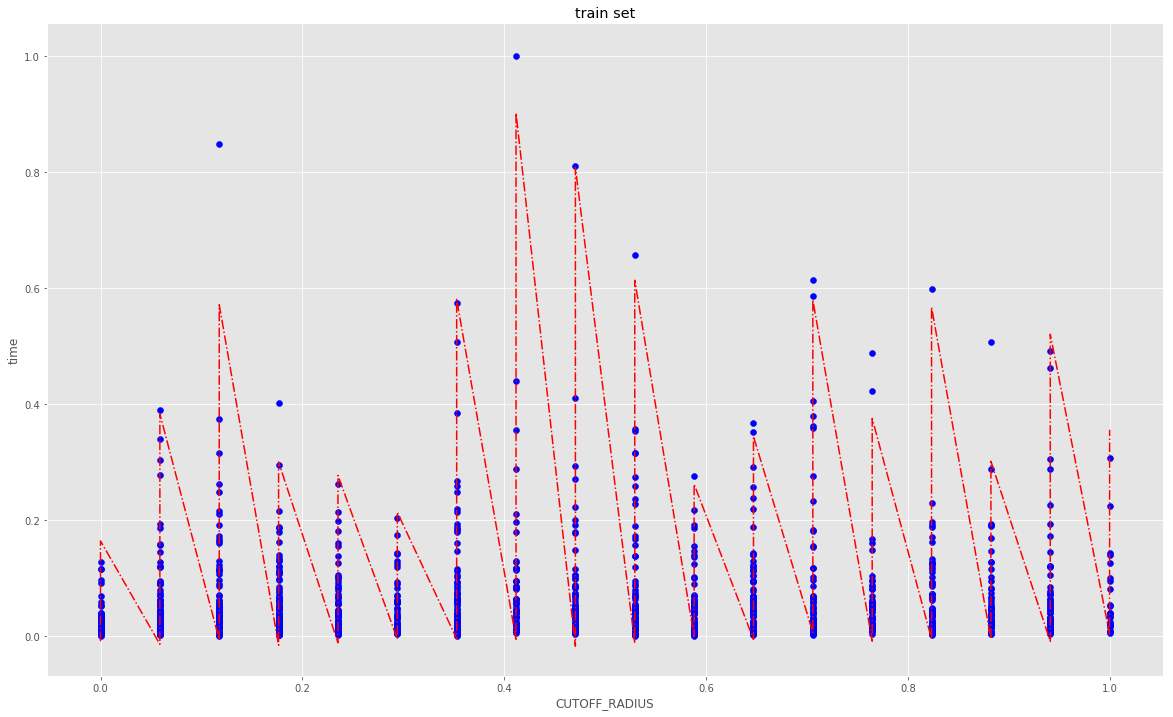

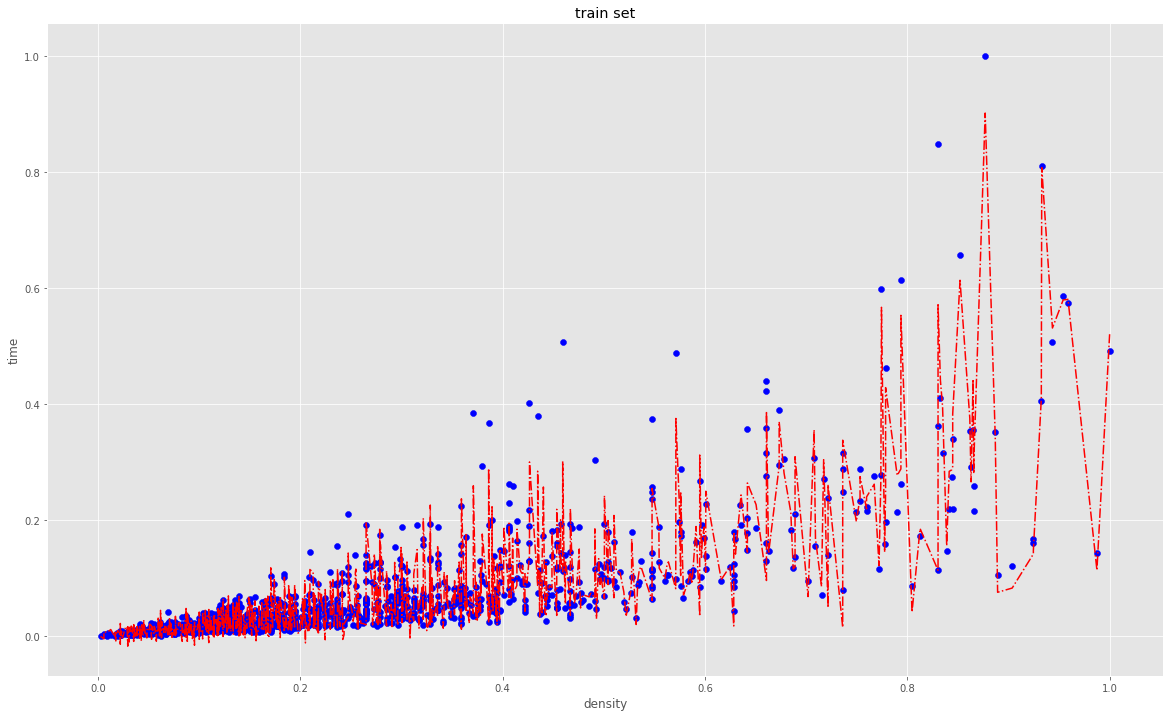

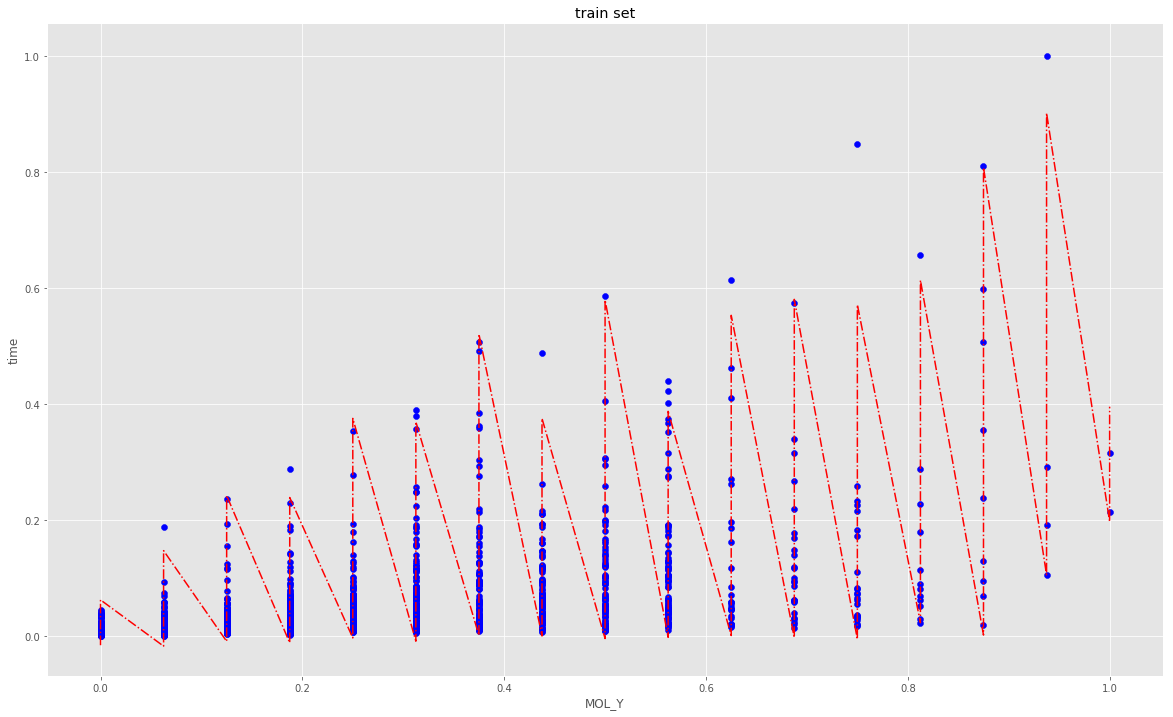

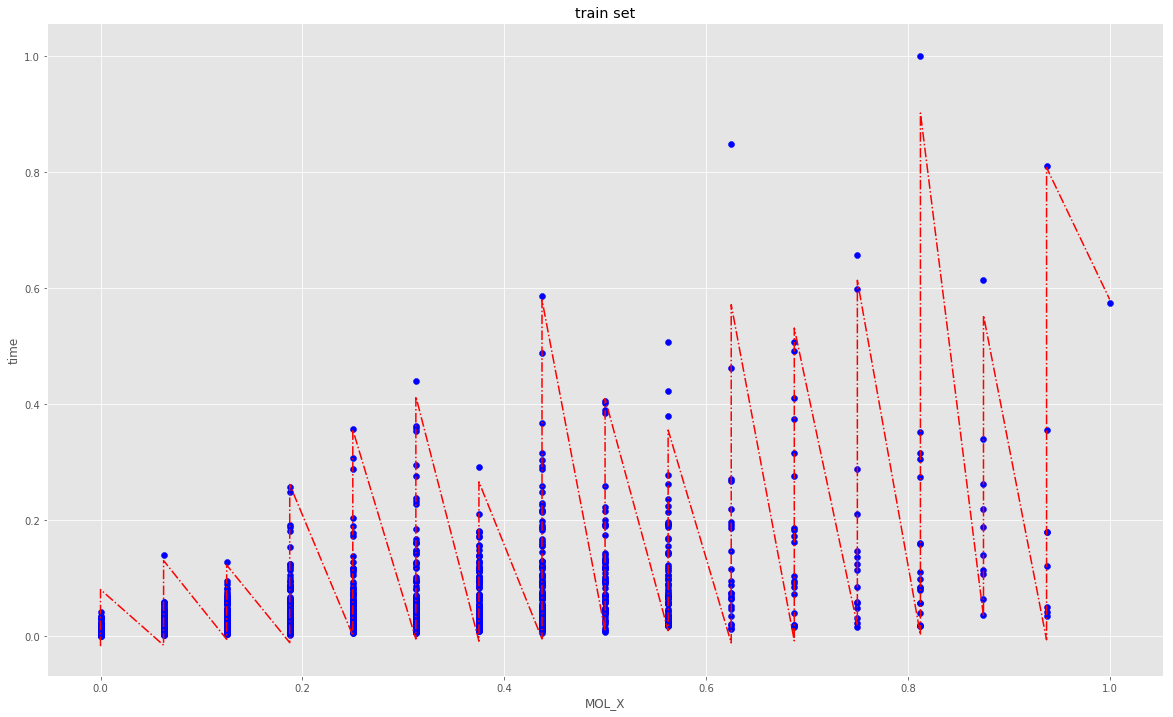

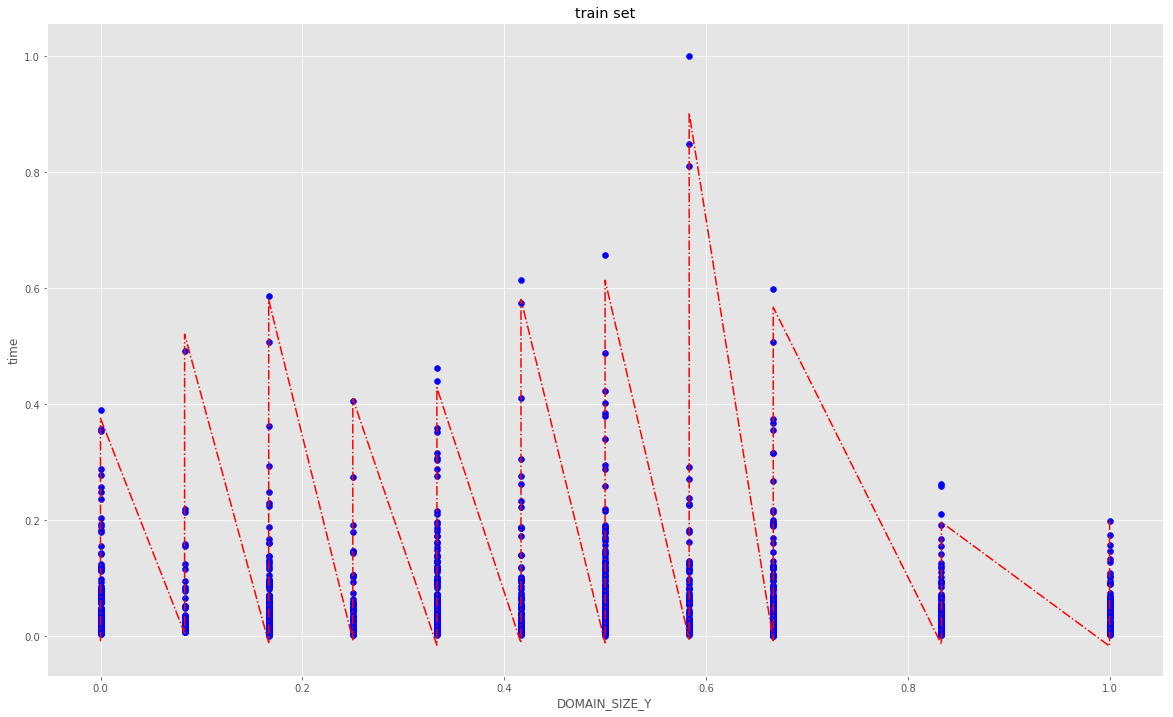

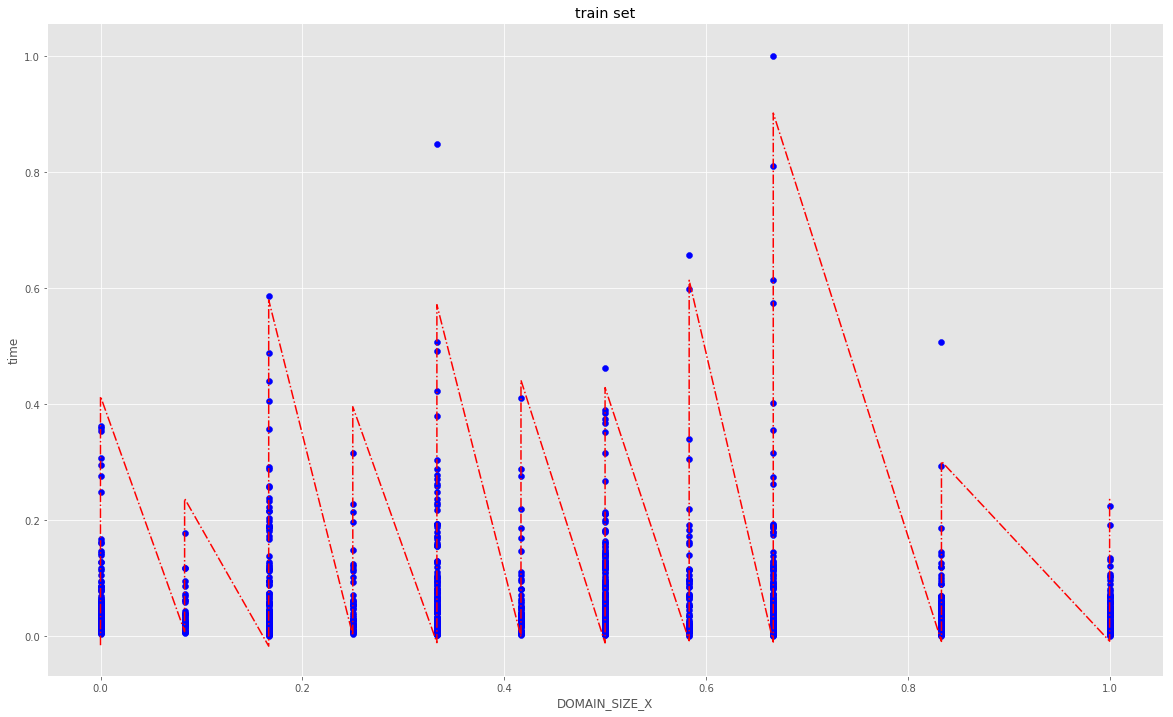

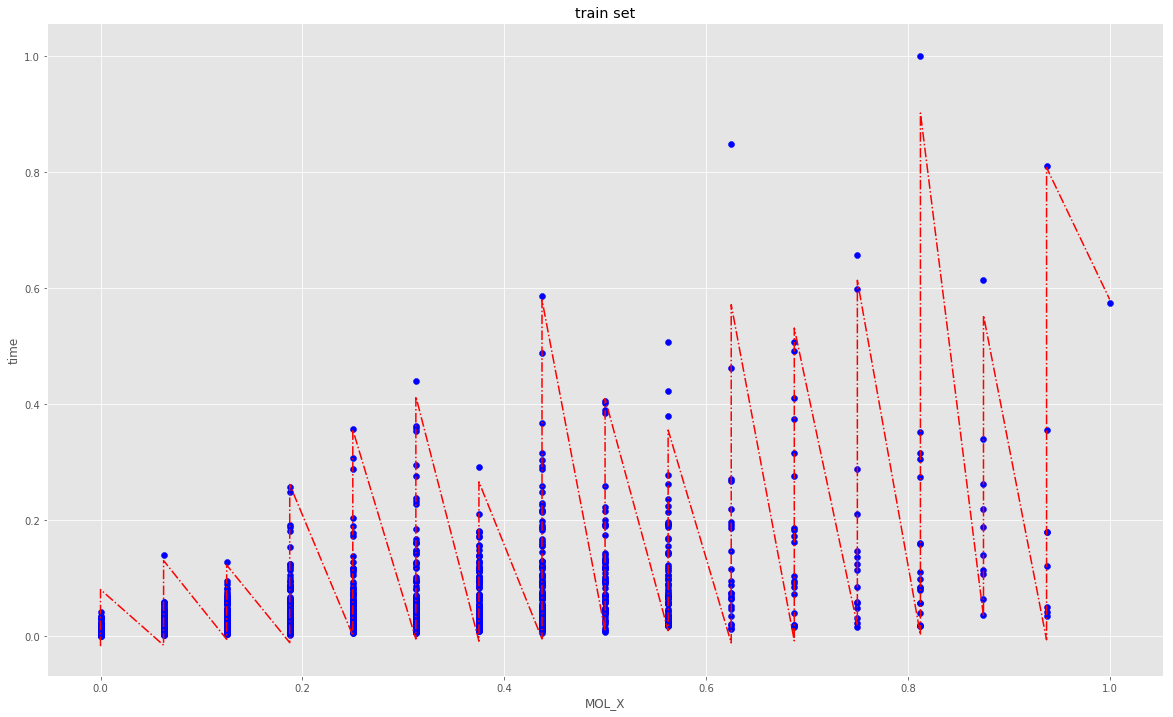

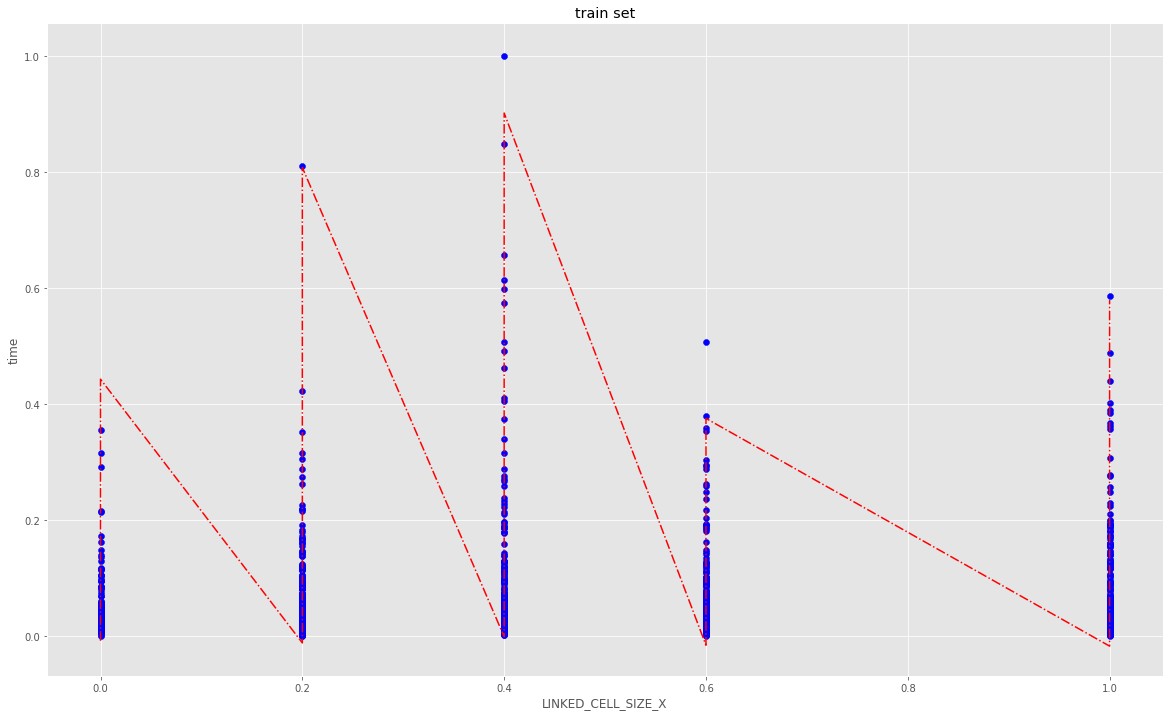

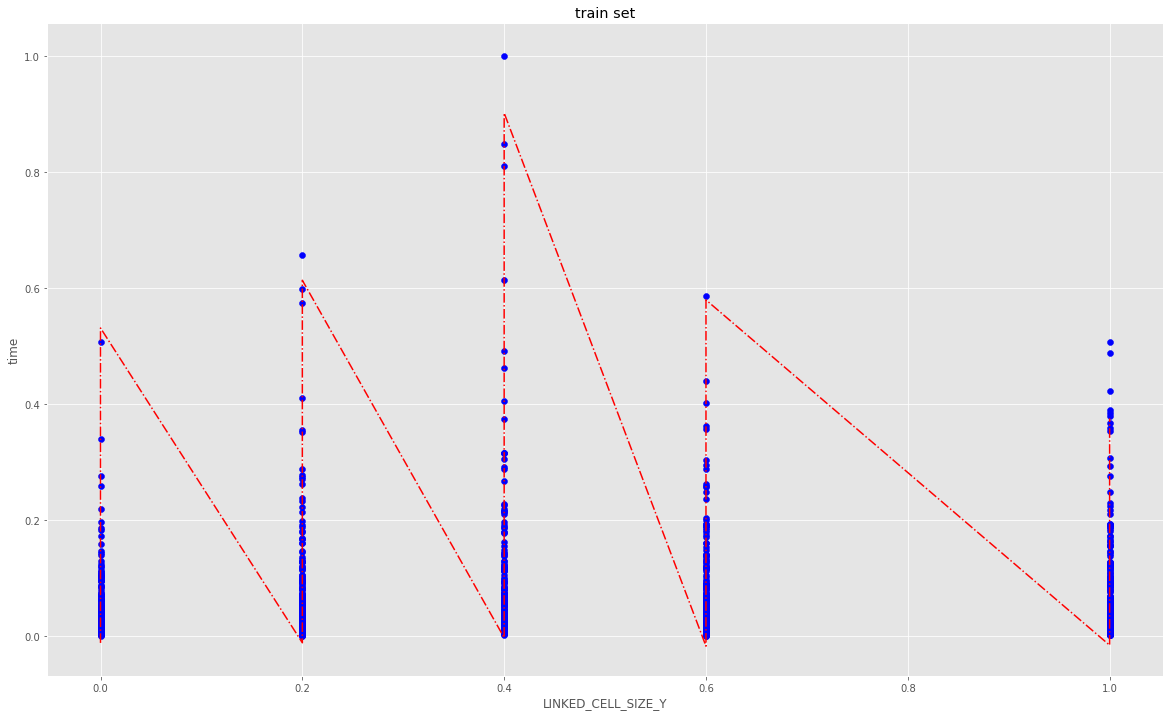

In [15]:
generatePairPlots(X_train, Y_train, learner.grid, learner.alpha, title='train set', outdir = '/media/sf_sparse_grids/pairPlots/train')

In [ ]:
df.to_csv('raw_data_16_1_2018.csv')